# Evaluation of topic modelling
This notebook aims to give an evaluation of the accuracy with which the topic of bills are identified.
We do this by comparing our results to the topics that are given to bills in the dataset, i.e. bills that have the same topic according to the dataset, should also have the same topic in our results.

In the dataset, each bill has a set of topics and one main topic. 

We will use two metrics for the evaluation, a strict and a loose metric. The strict metric requires the main topic of bills as specified in the dataset to match exactly. The loose metric requires at least $k$ topics to match in the sets of topics to consider two bills as being in the same category.

### Read results

In [3]:
import csv
import sys
import gensim
from collections import defaultdict, Counter

csv.field_size_limit(sys.maxsize)

131072

In [157]:
# Allow for changes in final format of the CSV file by making the relevant column ids variables
dataset_main_subject_column = 1

topic_column = 2
party_column = 4
results = 'processed_bills.csv'

In [158]:
# Create a dictionary of topics found in results with their respective bills
topics = defaultdict(list)
real_topics = Counter()
with open(results, newline='') as csvfile:
    csvfile.readline()
    rows = csv.reader(csvfile, delimiter='|')
    for row in rows:
        bill = dict()   
        bill['topic'] = row[topic_column]
        bill['dataset_main_subject'] = row[dataset_main_subject_column]
        bill['party'] = row[party_column]
        real_topics[bill['dataset_main_subject']] += 1
        topics[bill['topic']].append(bill)

In [159]:
len(real_topics)

1802

We now go over each identified topic and evaluate wether its bills are in fact have the same subject (according to the dataset)

### Strict metric

Find out how many 'actual topics' each identified topic contains

In [160]:
true_topics_per_topic = dict()
for topic, bills in topics.items():
    true_topics = Counter()
    for bill in bills:
        true_topic = bill['dataset_main_subject']
        true_topics[true_topic] += 1
    true_topics_per_topic[topic] = true_topics

In [161]:
bill_counts = []
frequencies = []

for topic, true_topics in true_topics_per_topic.items():
    n_bills = sum(true_topics.values())
    print("Topic:", topic)
    print("# bills:", n_bills)
    print("# real topics:", len(true_topics))
    print("Most common real topic frequency:", true_topics.most_common(1)[0][1] / n_bills)
    print("---------------------------------------")
    bill_counts.append(n_bills)
    frequencies.append(true_topics.most_common(1)[0][1] / n_bills)


Topic: 7
# bills: 1309
# real topics: 128
Most common real topic frequency: 0.3384262796027502
---------------------------------------
Topic: 25
# bills: 3818
# real topics: 171
Most common real topic frequency: 0.3431115767417496
---------------------------------------
Topic: 24
# bills: 1999
# real topics: 264
Most common real topic frequency: 0.22661330665332666
---------------------------------------
Topic: 30
# bills: 1600
# real topics: 143
Most common real topic frequency: 0.43
---------------------------------------
Topic: 10
# bills: 2342
# real topics: 201
Most common real topic frequency: 0.24722459436379163
---------------------------------------
Topic: 20
# bills: 4086
# real topics: 149
Most common real topic frequency: 0.23543808125305923
---------------------------------------
Topic: 6
# bills: 1893
# real topics: 191
Most common real topic frequency: 0.31484416270470156
---------------------------------------
Topic: 18
# bills: 8185
# real topics: 206
Most common real 

In [164]:
np.mean(frequencies)

0.2657706550246838

In [162]:
true_topics_per_topic['31'].most_common(10)

[('Armed forces and national security', 1205),
 ("Veterans' education", 208),
 ('Military pensions', 188),
 ('Private legislation', 170),
 ("Veterans' disability compensation", 150),
 ('Cemeteries and funerals', 134),
 ("Veterans' hospitals", 58),
 ('Military pay', 53),
 ("Veterans' benefits", 50),
 ('Federal incorporation', 49)]

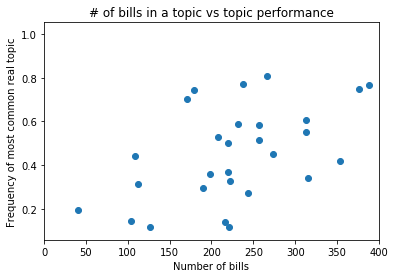

In [72]:
import matplotlib.pyplot as plt
import numpy as np

plt.xlabel("Number of bills")
plt.ylabel("Frequency of most common real topic")


plt.scatter(bill_counts, frequencies, label = "Topics")

plt.xlim(left=0, right=400)
plt.savefig('graphs/nbills-v-topic_perf.png')
plt.title("# of bills in a topic vs topic performance")
plt.show()

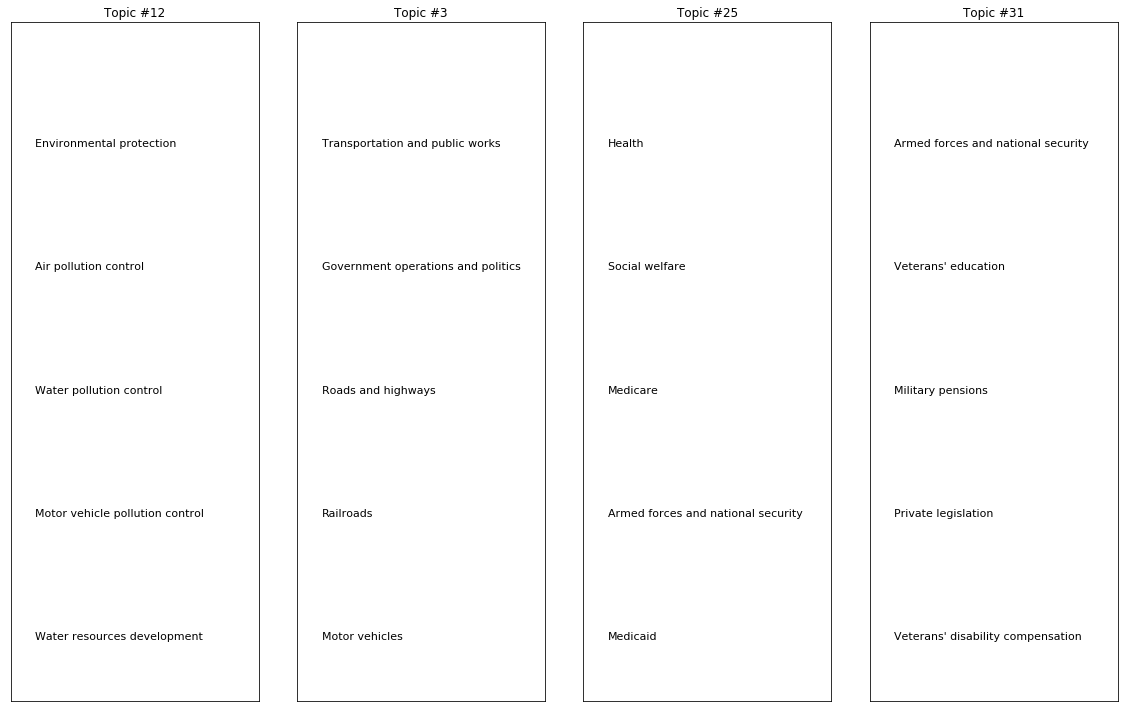

In [165]:
fig = plt.figure(figsize=(16, 10))

num_top_words = 5

#fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus
topics_to_plot = [true_topics_per_topic[str(x)] for x in [12, 3, 25,31]]
for i, topic in enumerate(topics_to_plot):
    plt.subplot(1, len(topics_to_plot), i + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format([12, 3, 25,31][i]))
    for i, (word, share) in enumerate(topic.most_common(num_top_words)):
        plt.text(0.1, num_top_words-i-0.5, word, fontsize=11)
        
plt.tight_layout()
plt.savefig('graphs/x.png')
plt.show()

# Democrat / Republican analysis

In [232]:
republican_topic_counts  = Counter()
democrat_topic_counts = Counter()
independent_count = 0
for topic, bills in topics.items():
    for bill in bills:
        if bill['party'].startswith('Republican'):
            republican_topic_counts[topic] += 1
        elif bill['party'].startswith('Democrat'):
            democrat_topic_counts[topic] += 1
        else:
            independent_count += 1

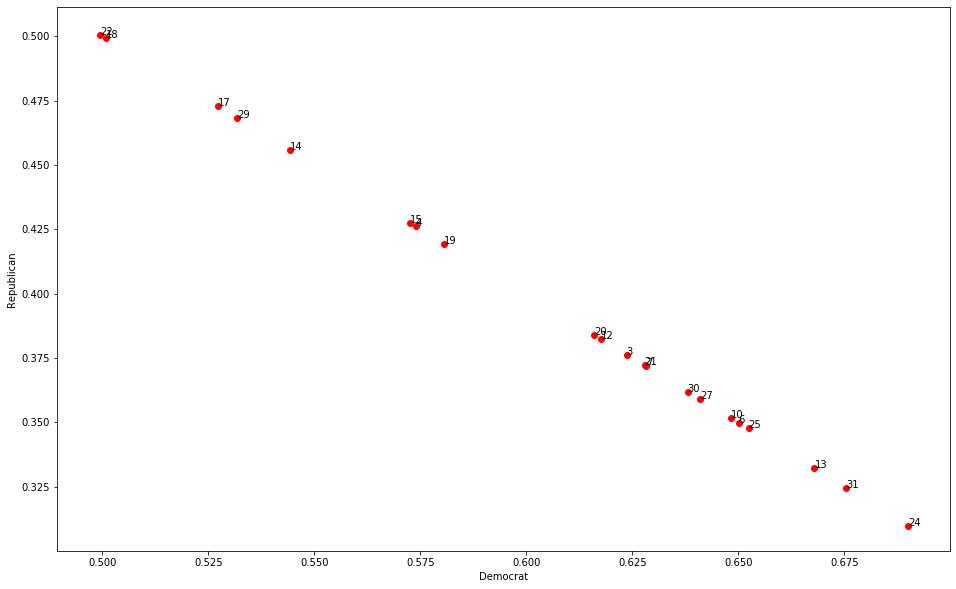

In [211]:
plt.figure(figsize=(16, 10))

for topic in topics:
    
    # don't show irrelevant topics
    n_bills = sum(true_topics_per_topic[topic].values())
    relevance = true_topics_per_topic[topic].most_common(1)[0][1] / n_bills
    if relevance < 0.2:
        continue
    
    republican_count = republican_topic_counts[topic]
    democrat_count = democrat_topic_counts[topic]
    total_count = democrat_count + republican_count
    
    democrat_freq = democrat_count / total_count
    republican_freq = republican_count / total_count
    
    
    plt.scatter(democrat_freq, republican_freq, marker='o', color='red')
    plt.annotate(topic, (democrat_freq, republican_freq))
    
plt.xlabel("Democrat")
plt.ylabel("Republican")
plt.savefig('graphs/topic_parties.png')
plt.show()

[('18', 4075), ('21', 2041), ('22', 1946), ('29', 1750)]

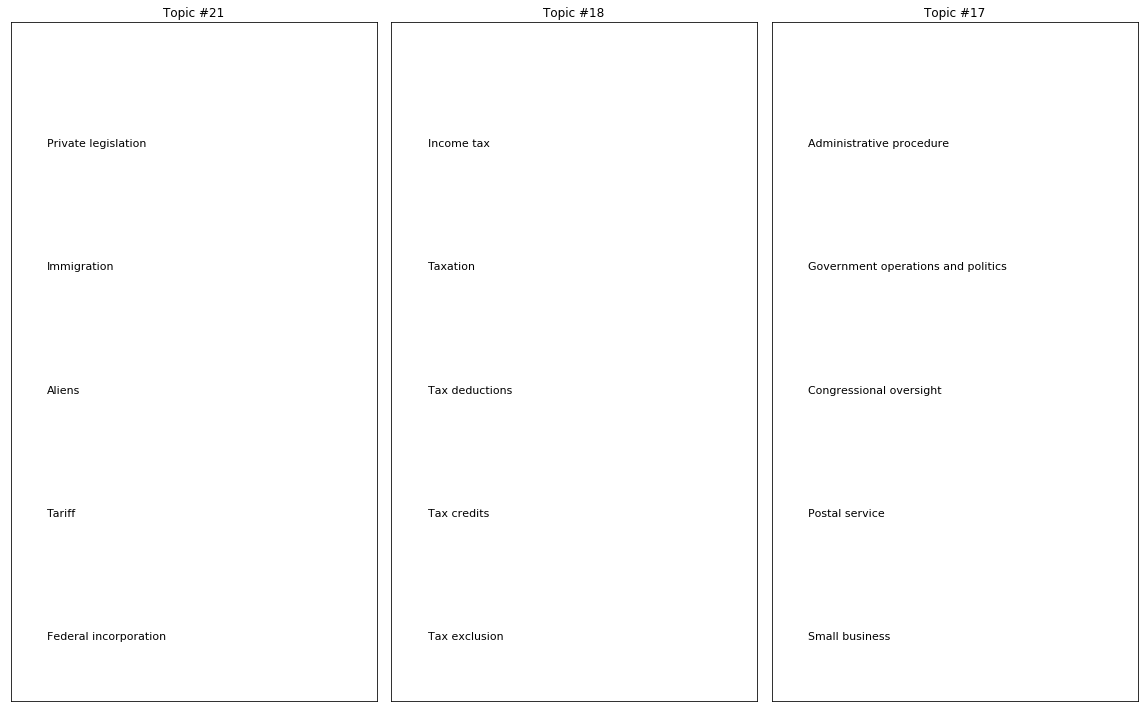

In [225]:
fig = plt.figure(figsize=(16, 10))

num_top_words = 5

republican_topics = [21,18,17]

#fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus
topics_to_plot = [true_topics_per_topic[str(x)] for x in republican_topics]
for i, topic in enumerate(topics_to_plot):
    plt.subplot(1, len(topics_to_plot), i + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(republican_topics[i]))
    for i, (word, share) in enumerate(topic.most_common(num_top_words)):
        plt.text(0.1, num_top_words-i-0.5, word, fontsize=11)
        
plt.tight_layout()
plt.savefig('graphs/republican_topics.png')
plt.show()

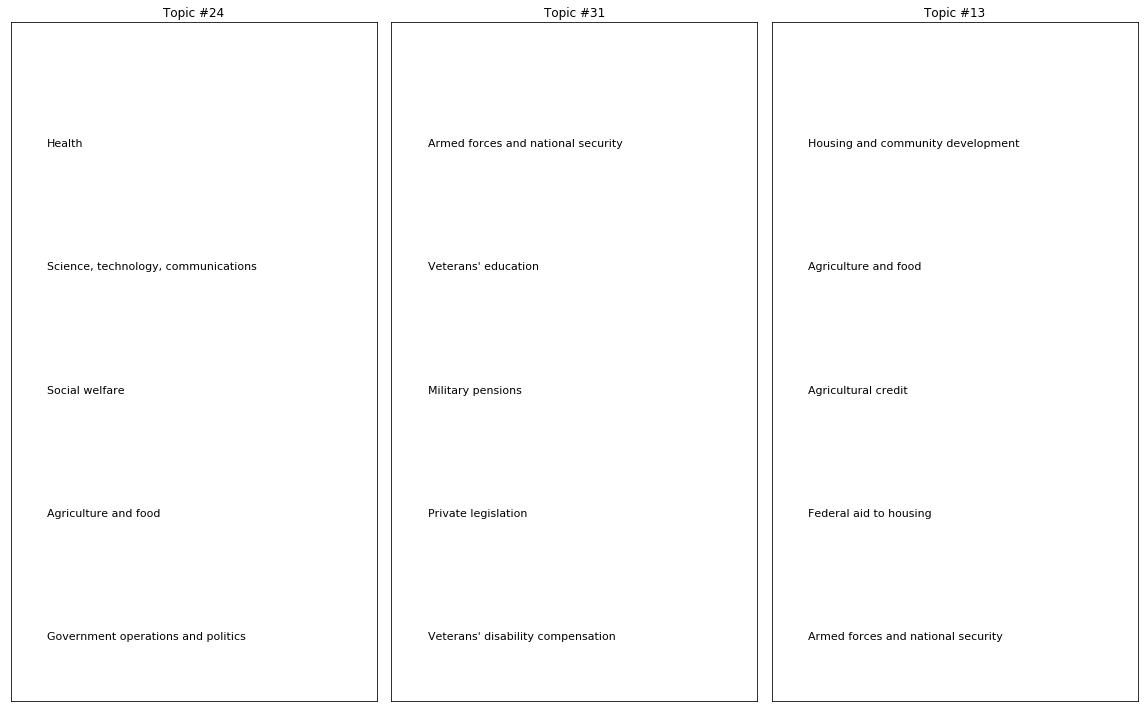

In [227]:
fig = plt.figure(figsize=(16, 10))

num_top_words = 5

republican_topics = [24,31,13]

#fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus
topics_to_plot = [true_topics_per_topic[str(x)] for x in republican_topics]
for i, topic in enumerate(topics_to_plot):
    plt.subplot(1, len(topics_to_plot), i + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(republican_topics[i]))
    for i, (word, share) in enumerate(topic.most_common(num_top_words)):
        plt.text(0.1, num_top_words-i-0.5, word, fontsize=11)
        
plt.tight_layout()
plt.savefig('graphs/democrat_topics.png')
plt.show()

In [228]:
sum(republican_topic_counts.values())

32856

In [230]:
sum(democrat_topic_counts.values())

47587

In [231]:
len(bills)

310

In [233]:
print(independent_count)

430
